# VietNamese Music Classification
## 1. Data-preprocessing

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [44]:
import os
import glob
import pandas as pd

# Đường dẫn đến thư mục chứa các file CSV
directory = './data'

# Tìm tất cả các file CSV trong thư mục
all_files = glob.glob(os.path.join(directory, '*.csv'))

# Đọc và gộp các file CSV thành một DataFrame
df_from_each_file = (pd.read_csv(f) for f in all_files)
merged_df = pd.concat(df_from_each_file, ignore_index=True)

# Lưu DataFrame gộp thành một file CSV
merged_df.to_csv('all_data.csv', index=False)

In [45]:
dataset = pd.read_csv('./all_data.csv')

In [4]:
dataset.head()

,Unnamed: 0,filename,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0,72_Nói Với Em Rằng... - Bùi Anh Tuấn _Official...,0.239606,0.088226,0.100619,0.007034,1574.444990,544040.065296,2224.814467,284067.593368,...,89.418810,0.118583,68.827360,-1.935302,71.693900,3.287505,96.955734,-7.828844,94.283900,ballad
1,1,96_Yêu Thương Ngày Đó - SOOBIN Hoàng Sơn,0.279810,0.086356,0.108011,0.002598,1669.862977,532744.220849,2079.801580,222307.077317,...,78.416466,-7.484340,75.549130,-0.149236,72.972340,-2.338418,85.452460,-6.283576,138.789260,ballad
2,2,25_Chẳng Ai Đến Thế Giới Này Để Cô Đơn,0.224870,0.086093,0.195526,0.015495,1049.548392,463953.746344,1336.162599,863011.108564,...,94.493965,-7.304261,74.785904,-3.813618,79.665250,-5.267002,96.953660,-6.046769,102.859360,ballad
3,3,41_Chua Bao Gio,0.224099,0.086295,0.085731,0.002403,1406.810672,342871.230130,1680.324965,201474.808183,...,117.047420,-4.986906,123.561220,-1.311286,115.603424,-7.030957,127.136140,-1.071963,175.931080,ballad
4,4,5_Khoc Cung Em,0.314306,0.090720,0.261103,0.006896,2669.434127,708916.480682,2746.789623,194569.102027,...,75.235054,1.617485,103.620310,5.682794,105.249954,-1.578305,88.727880,-0.139855,81.884926,ballad


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647 entries, 0 to 646
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               647 non-null    int64  
 1   filename                 647 non-null    object 
 2   chroma_stft_mean         647 non-null    float64
 3   chroma_stft_var          647 non-null    float64
 4   rms_mean                 647 non-null    float64
 5   rms_var                  647 non-null    float64
 6   spectral_centroid_mean   647 non-null    float64
 7   spectral_centroid_var    647 non-null    float64
 8   spectral_bandwidth_mean  647 non-null    float64
 9   spectral_bandwidth_var   647 non-null    float64
 10  rolloff_mean             647 non-null    float64
 11  rolloff_var              647 non-null    float64
 12  zero_crossing_rate_mean  647 non-null    float64
 13  zero_crossing_rate_var   647 non-null    float64
 14  harmony_mean             6

In [6]:
for i in range(len(dataset.columns)):
    missing_data = dataset[dataset.columns[i]].isna().sum()
    perc = missing_data / len(dataset) * 100
    print('>%d,  missing entries: %d, percentage %.2f' % (i, missing_data, perc))

>0,  missing entries: 0, percentage 0.00
>1,  missing entries: 0, percentage 0.00
>2,  missing entries: 0, percentage 0.00
>3,  missing entries: 0, percentage 0.00
>4,  missing entries: 0, percentage 0.00
>5,  missing entries: 0, percentage 0.00
>6,  missing entries: 0, percentage 0.00
>7,  missing entries: 0, percentage 0.00
>8,  missing entries: 0, percentage 0.00
>9,  missing entries: 0, percentage 0.00
>10,  missing entries: 0, percentage 0.00
>11,  missing entries: 0, percentage 0.00
>12,  missing entries: 0, percentage 0.00
>13,  missing entries: 0, percentage 0.00
>14,  missing entries: 0, percentage 0.00
>15,  missing entries: 0, percentage 0.00
>16,  missing entries: 0, percentage 0.00
>17,  missing entries: 0, percentage 0.00
>18,  missing entries: 0, percentage 0.00
>19,  missing entries: 0, percentage 0.00
>20,  missing entries: 0, percentage 0.00
>21,  missing entries: 0, percentage 0.00
>22,  missing entries: 0, percentage 0.00
>23,  missing entries: 0, percentage 0.00
>2

<Axes: >

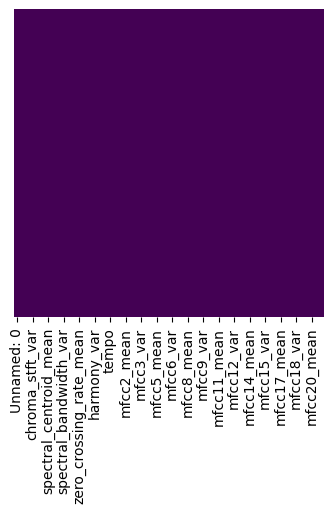

In [7]:
plt.figure(figsize = (4,4)) #is to create a figure object with a given size
sns.heatmap(dataset.isna(), cbar=False, cmap='viridis', yticklabels=False)

In [46]:
#convert the dataframe into a numpy array by calling values on my dataframe (not necessary), but a habit I prefer
X= dataset.iloc[:, 2:-1].values
y = dataset.iloc[:, -1].values

In [9]:
print(X)

[[ 2.3960630e-01  8.8225976e-02  1.0061858e-01 ...  9.6955734e+01
  -7.8288445e+00  9.4283900e+01]
 [ 2.7981030e-01  8.6356050e-02  1.0801109e-01 ...  8.5452460e+01
  -6.2835760e+00  1.3878926e+02]
 [ 2.2487031e-01  8.6093200e-02  1.9552603e-01 ...  9.6953660e+01
  -6.0467690e+00  1.0285936e+02]
 ...
 [ 2.9128050e-01  8.7488234e-02  1.2414071e-01 ...  7.3819050e+01
  -5.1070023e+00  7.0514050e+01]
 [ 4.3724477e-01  7.9985050e-02  2.8923760e-01 ...  4.9560314e+01
  -4.7211680e+00  6.3157978e+01]
 [ 3.7985608e-01  8.6184570e-02  9.3056254e-02 ...  5.4638226e+01
  -2.6495160e+00  5.3403027e+01]]


In [10]:
print(y)

['ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad'
 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad'
 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad'
 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad'
 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad'
 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad'
 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad'
 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad'
 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad'
 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad'
 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad'
 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad' 'ballad'
 'ballad' 'ballad' 'ballad' 'ballad' 'bolero' 'bolero' 'bolero' 'bolero'
 'bolero' 'bolero' 'bolero' 'bolero' 'bolero' 'bole

In [47]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#output of fit_transform of Label Encoder is already a Numpy Array
y = le.fit_transform(y)

In [12]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [14]:
print(X_train)

[[ 2.9370308e-01  8.6973585e-02  2.4819909e-01 ...  1.2562819e+02
  -6.4264800e+00  1.6670479e+02]
 [ 3.8871622e-01  1.0127428e-01  1.9115900e-01 ...  1.6776123e+02
   8.2514780e+00  1.8524539e+02]
 [ 2.5244427e-01  8.4036120e-02  2.2917019e-01 ...  1.8037495e+02
   7.5878606e+00  1.3294696e+02]
 ...
 [ 2.3419183e-01  9.1920150e-02  1.5135646e-01 ...  1.3832104e+02
  -5.1615496e+00  1.7419669e+02]
 [ 3.9101255e-01  9.4228946e-02  2.7949286e-01 ...  7.1908890e+01
  -2.2605565e+00  7.6271580e+01]
 [ 2.5027224e-01  9.1549120e-02  1.8906277e-01 ...  9.6076860e+01
  -6.5985007e+00  9.2879776e+01]]


In [15]:
print(X_test)

[[ 2.66507570e-01  8.83412360e-02  1.95405400e-01 ...  2.25410170e+02
   6.19917350e+00  2.01887010e+02]
 [ 3.04428280e-01  8.59865250e-02  1.83409800e-01 ...  7.79041060e+01
  -5.96130900e+00  9.93338240e+01]
 [ 3.85924700e-01  9.15586200e-02  2.10209800e-01 ...  8.43001700e+01
   2.07371700e+00  8.77118500e+01]
 ...
 [ 2.88240580e-01  9.39971100e-02  1.35877040e-01 ...  1.20350136e+02
  -3.92788500e+00  9.07031400e+01]
 [ 3.14929200e-01  9.01425300e-02  1.77883850e-01 ...  1.34896820e+02
   2.18855980e+00  1.20490166e+02]
 [ 3.15397320e-01  8.88622100e-02  2.34784050e-01 ...  5.91260400e+01
   3.59254360e+00  7.28750600e+01]]


In [16]:
print(y_train)

[3 3 3 0 3 0 5 5 4 3 4 4 2 2 1 2 4 0 5 3 0 1 0 4 2 4 5 5 3 5 2 2 0 2 0 4 5
 0 2 5 3 1 1 0 1 0 5 4 3 1 3 4 5 3 4 0 3 5 0 3 4 1 5 1 2 0 5 3 0 5 2 0 3 3
 1 5 0 3 5 1 0 0 4 4 3 0 3 2 5 5 1 4 0 0 0 1 4 0 1 3 0 1 3 2 5 5 1 3 3 5 1
 4 4 5 3 3 5 5 5 1 4 2 4 1 1 1 4 5 4 1 0 3 3 0 3 1 5 1 4 3 5 4 1 5 0 2 4 2
 3 0 2 5 2 3 3 0 4 2 0 2 0 1 4 2 4 4 5 2 4 5 0 2 2 2 3 1 1 4 5 3 0 3 2 2 2
 2 5 4 2 1 5 1 5 5 5 2 5 3 2 5 0 3 3 0 3 5 0 4 1 5 0 3 0 0 3 0 1 1 4 5 4 3
 0 3 5 1 5 3 0 5 4 5 4 2 1 5 3 1 3 0 5 0 2 3 1 1 4 1 2 3 1 1 5 0 2 1 2 4 2
 3 2 1 1 3 5 4 2 2 1 3 2 4 2 1 4 1 1 4 2 1 4 3 1 4 2 2 1 2 3 5 5 4 4 4 3 5
 1 5 0 2 4 2 3 4 2 1 2 5 3 5 0 2 3 5 5 1 2 2 5 1 2 0 5 1 0 2 1 3 1 0 0 0 0
 0 0 1 1 3 2 0 2 5 0 1 5 5 3 0 0 5 5 0 4 4 0 3 0 4 3 5 4 3 3 4 4 2 3 5 3 0
 4 4 5 3 5 1 2 5 2 0 2 5 4 3 2 4 1 2 5 5 5 4 5 2 3 3 1 5 5 4 2 0 1 3 5 1 3
 2 4 5 2 4 1 3 5 4 1 1 4 4 1 5 0 2 0 2 5 5 5 5 5 3 0 0 2 1 4 5 4 5 4 2 3 3
 1 3 1 3 2 0 5 4 2 1 5 1 3 3 2 1 0 2 4 3 0 1 0 0 4 3 3 0 5 0 4 4 5 5 4 3 0
 5 4 4 2 2 3 4 3 5 3 0 3 

In [17]:
print(y_test)

[3 4 5 3 4 4 5 5 1 3 1 0 5 4 1 0 2 3 2 0 0 5 4 4 0 2 5 0 3 2 5 0 5 5 4 1 4
 3 3 0 0 3 1 3 0 0 3 5 1 2 5 1 0 5 4 1 2 3 2 1 5 4 5 2 2 0 4 2 3 3 5 5 5 1
 0 0 4 5 3 2 5 2 5 3 1 0 0 1 4 1 5 3 5 1 4 4 3 5 5 5 4 4 3 2 0 1 1 5 1 5 4
 5 3 5 5 1 3 3 4 2 5 3 4 3 4 0 2 2 3 3]


In [49]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:,:] = sc.fit_transform(X_train[:,:])
#only use Transform to use the SAME scaler as the Training Set
X_test[:,:] = sc.transform(X_test[:,:])

In [19]:
print(X_test)

[[-0.73653345 -0.14109907  0.11876118 ...  2.64786434  1.61216186
   1.88343925]
 [-0.22289991 -0.70341979 -0.05782207 ... -0.44183041 -1.24600955
  -0.08259596]
 [ 0.88096378  0.62723371  0.33669184 ... -0.30785703  0.6425242
  -0.30539947]
 ...
 [-0.44216125  1.20956141 -0.75753605 ...  0.44725355 -0.76807832
  -0.2480538 ]
 [-0.08066563  0.28906196 -0.13916774 ...  0.75195162  0.66951658
   0.32298982]
 [-0.07432498 -0.016687    0.69844122 ... -0.83515995  0.99950566
  -0.58983385]]


In [20]:
print(X_test)

[[-0.73653345 -0.14109907  0.11876118 ...  2.64786434  1.61216186
   1.88343925]
 [-0.22289991 -0.70341979 -0.05782207 ... -0.44183041 -1.24600955
  -0.08259596]
 [ 0.88096378  0.62723371  0.33669184 ... -0.30785703  0.6425242
  -0.30539947]
 ...
 [-0.44216125  1.20956141 -0.75753605 ...  0.44725355 -0.76807832
  -0.2480538 ]
 [-0.08066563  0.28906196 -0.13916774 ...  0.75195162  0.66951658
   0.32298982]
 [-0.07432498 -0.016687    0.69844122 ... -0.83515995  0.99950566
  -0.58983385]]


## 2.Train

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

In [71]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(max_iter=10000), 
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Decision Tree": DecisionTreeClassifier(),
          "SVM": SVC(),
          "GBM": GradientBoostingClassifier(),
          "Naive Bayes": GaussianNB()}

# Creat a funciton to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels associated with training data
    y_test : labels associated with test data
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores and trained models
    model_scores = {}
    trained_models = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
        # Save the trained model
        trained_models[name] = model
    return model_scores, trained_models


In [72]:

model_scores, trained_models = fit_and_score(models=models,
                                             X_train=X_train,
                                             X_test=X_test,
                                             y_train=y_train,
                                             y_test=y_test)
model_scores

{'Logistic Regression': 0.8846153846153846,
 'KNN': 0.7769230769230769,
 'Random Forest': 0.823076923076923,
 'Decision Tree': 0.6230769230769231,
 'SVM': 0.8615384615384616,
 'GBM': 0.823076923076923,
 'Naive Bayes': 0.7153846153846154}

In [54]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare

,Logistic Regression,KNN,Random Forest,Decision Tree,SVM,GBM,Naive Bayes
accuracy,0.884615,0.776923,0.823077,0.623077,0.861538,0.823077,0.715385


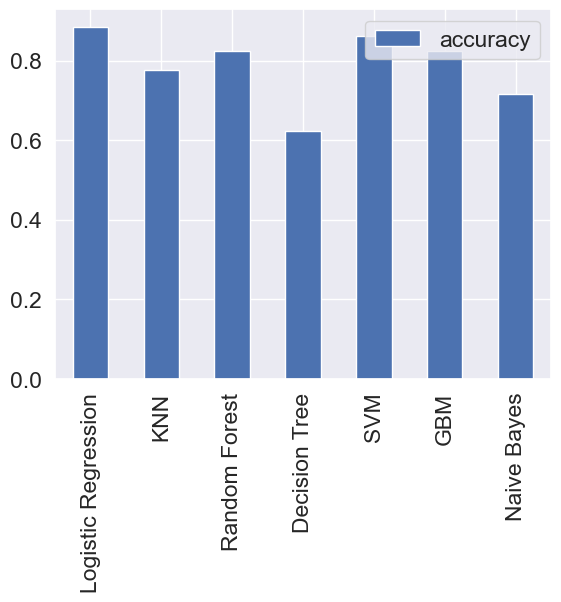

In [55]:
model_compare.T.plot.bar();

In [62]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [63]:
# Create a hyper-parameter grid for LogisticRegression()

log_reg_grid = {"C": np.logspace(-4,4,20), #most valuable for Log Reg model
                "solver": ["liblinear"]}

# Create a hyper-parameter grid for RandomForestClassifier()
rf_grid = {"n_estimators": np.arange(10,1000,50),
           "max_depth": [None, 3,5,10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf": np.arange(1,20,2)}
# Create a hyper-parameter grid for SVM
svm_grid = {'C': np.logspace(-3, 3, 10), 
            'gamma': ['scale', 'auto'], 
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
# Create a hyper-parameter grid for GradientBoostingClassifier
gbm_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2], 
            'n_estimators': [50, 100, 200], 
            'max_depth': [3, 5, 7, 9], 
            'min_samples_split': [2, 5, 10], 
            'min_samples_leaf': [1, 2, 4]}

In [64]:
# Put models in a dictionary
params_grid = {"Logistic Regression": (LogisticRegression(max_iter=10000), log_reg_grid),
               "Random Forest": (RandomForestClassifier(), rf_grid),
               "SVM": (SVC(), svm_grid),
               "GBM": (GradientBoostingClassifier(), gbm_grid)}

# Creat a funciton to hyperparameter tuning with RandomizedSearchCV
def tune(params_grid, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    rs_scores = {}
    for name, (model, param_grid) in params_grid.items():
        rs = RandomizedSearchCV(model, param_distributions=param_grid, cv=5, n_iter=20, verbose=True, n_jobs=-1)
        rs.fit(X_train, y_train)
        rs_scores[name] = rs.score(X_test, y_test)
    return rs_scores

In [65]:
rs_scores = tune(params_grid=params_grid,
                            X_train=X_train,
                            X_test=X_test,
                            y_train=y_train,
                            y_test=y_test)
rs_scores

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'Logistic Regression': 0.8538461538461538,
 'Random Forest': 0.8,
 'SVM': 0.8461538461538461,
 'GBM': 0.823076923076923}

In [66]:
# Different hyperparameters for our LogisticRegression model
log_reg_grid = {"C": np.logspace(-4, 4, 30),
                "solver": ["liblinear"]}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
gs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [67]:
# Evaluate the grid search LogisticRegression model
gs_log_reg.score(X_test, y_test)


0.8461538461538461

## 3. Evaluation

In [78]:
## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score #Classification Problem

In [82]:
logistic_regression_model = trained_models["Logistic Regression"]
y_preds = logistic_regression_model.predict(X_test)

In [83]:
print(confusion_matrix(y_test, y_preds))

[[18  0  0  0  1  0]
 [ 0 15  0  1  0  0]
 [ 2  0 16  1  0  0]
 [ 0  1  0 18  0  0]
 [ 4  0  0  0 18  1]
 [ 0  0  0  3  1 30]]


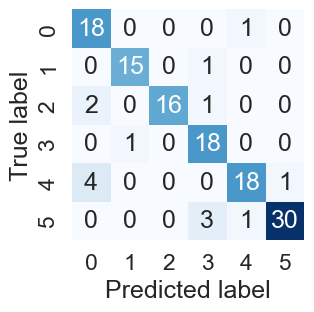

In [84]:
sns.set(font_scale=1.5) # Increase font size
 
def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False,
                     cmap="Blues")
    plt.xlabel("Predicted label") # predictions go on the x-axis
    plt.ylabel("True label") # true labels go on the y-axis 
    
plot_conf_mat(y_test, y_preds)

In [85]:
print(classification_report(y_test, y_preds)) #Based on only 1 test set

              precision    recall  f1-score   support

           0       0.75      0.95      0.84        19
           1       0.94      0.94      0.94        16
           2       1.00      0.84      0.91        19
           3       0.78      0.95      0.86        19
           4       0.90      0.78      0.84        23
           5       0.97      0.88      0.92        34

    accuracy                           0.88       130
   macro avg       0.89      0.89      0.88       130
weighted avg       0.90      0.88      0.89       130

